In [ ]:
from typing import List, Tuple, Dict, Any, Optional
import math
import time
import json
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models

def compute_bounds_from_json(json_path: Path, pad: float = 0.01) -> Tuple[float,float,float,float]:
    """
    Прочитать exif_data.json и вернуть (LAT_MIN, LAT_MAX, LON_MIN, LON_MAX) с паддингом.
    Поддерживает ключи: gps_latitude/latitude/lat и gps_longitude/longitude/lon.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    lats, lons = [], []
    for row in data:
        lat = row.get('gps_latitude', row.get('latitude', row.get('lat', None)))
        lon = row.get('gps_longitude', row.get('longitude', row.get('lon', None)))
        if lat is None or lon is None:
            continue
        lats.append(float(lat)); lons.append(float(lon))
    if not lats:
        raise ValueError(f"No lat/lon found in {json_path}")
    lat_min, lat_max = float(np.min(lats)), float(np.max(lats))
    lon_min, lon_max = float(np.min(lons)), float(np.max(lons))
    # небольшой паддинг
    dlat = (lat_max - lat_min) * pad or 1e-6
    dlon = (lon_max - lon_min) * pad or 1e-6
    return lat_min - dlat, lat_max + dlat, lon_min - dlon, lon_max + dlon

def meters_error(pred_lat, pred_lon, gt_lat, gt_lon):
    """Приближение в метрах (нормально на малых расстояниях в Москве)."""
    lat_m = (pred_lat - gt_lat) * 111_000.0
    lon_m = (pred_lon - gt_lon) * 111_000.0 * np.cos(np.deg2rad(gt_lat))
    return np.sqrt(lat_m**2 + lon_m**2)

class AdvancedGPSDatasetMSK(Dataset):
    """
    Адаптация датасета из main2_high_improved.py под наш JSON/путь.
    - Поддерживает как 'image_path' (абсолютный), так и 'filename' (+ image_dir).
    - Нормализация координат в [-1, 1] по bounds, которые считаются по JSON.
    - Аугментации как в оригинале (слегка), но без SF-фильтров.
    """
    def __init__(self, image_dir: str, json_path: str, is_training: bool, bounds: Tuple[float,float,float,float]):
        super().__init__()
        self.image_dir = Path(image_dir)
        self.is_training = is_training
        self.LAT_MIN, self.LAT_MAX, self.LON_MIN, self.LON_MAX = bounds

        with open(json_path, 'r') as f:
            data_list = json.load(f)

        self.image_paths: List[str] = []
        self.norm_coords: List[List[float]] = []
        self.raw_coords: List[List[float]] = []

        if is_training:
            self.transform = transforms.Compose([
                transforms.Resize((288, 288)),
                transforms.RandomResizedCrop(256, scale=(0.6, 1.0), ratio=(0.9, 1.1)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.25, saturation=0.2, hue=0.05),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
            ])

        skipped = 0
        for row in data_list:
            lat = row.get('gps_latitude', row.get('latitude', row.get('lat', None)))
            lon = row.get('gps_longitude', row.get('longitude', row.get('lon', None)))
            if lat is None or lon is None:
                skipped += 1; continue
            lat, lon = float(lat), float(lon)

            # путь
            p = row.get('image_path', None)
            if p is None:
                fname = row.get('filename', None)
                if fname is None: skipped += 1; continue
                p = str(self.image_dir / fname)
            if not os.path.isfile(p):
                skipped += 1; continue

            # нормализация в [-1, 1] по bounds
            nlat = 2.0*(lat - self.LAT_MIN)/(self.LAT_MAX - self.LAT_MIN) - 1.0
            nlon = 2.0*(lon - self.LON_MIN)/(self.LON_MAX - self.LON_MIN) - 1.0

            self.image_paths.append(p)
            self.raw_coords.append([lat, lon])
            self.norm_coords.append([nlat, nlon])

        if skipped:
            print(f"[dataset] skipped {skipped} entries (missing path/coords)")
        print(f"[dataset] loaded {len(self.image_paths)} images")
        print(f"[dataset] LAT: [{self.LAT_MIN:.6f}, {self.LAT_MAX:.6f}]  LON: [{self.LON_MIN:.6f}, {self.LON_MAX:.6f}]")

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, i: int):
        img = Image.open(self.image_paths[i]).convert('RGB')
        x = self.transform(img)
        nlat, nlon = self.norm_coords[i]
        alat, alon = self.raw_coords[i]
        return x, torch.tensor([nlat, nlon], dtype=torch.float32), torch.tensor([alat, alon], dtype=torch.float32), self.image_paths[i]

In [ ]:
!pip install transformers

In [ ]:
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights

class ProperTerrainClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Загрузка весов с fallback, если нет интернета
        try:
            backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        except Exception as e:
            print("[warn] resnet50 weights download failed, using random init:", e)
            backbone = models.resnet50(weights=None)
        self.backbone = backbone
        nf = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.terrain_head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(nf, 512), nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 6),  # urban, water, forest, grassland, mountain, beach
        )
        self.classes = ['urban','water','forest','grassland','mountain','beach']

    def analyze_color_features(self, x: torch.Tensor) -> torch.Tensor:
        # как в исходнике: слабая эвристика по цветам
        b, c, h, w = x.shape
        scores = torch.zeros((b, 6), device=x.device, dtype=x.dtype)
        x_np = x.detach().cpu().permute(0,2,3,1).numpy()
        for i in range(b):
            mean_rgb = np.mean(x_np[i], axis=(0,1))
            # water
            if mean_rgb[2] > mean_rgb[1] and mean_rgb[2] > mean_rgb[0]:
                scores[i,1] += 0.3
            # forest
            if mean_rgb[1] > mean_rgb[0] and mean_rgb[1] > mean_rgb[2]:
                scores[i,2] += 0.3
            # urban (низкая вариативность)
            if np.var(mean_rgb) < 0.05:
                scores[i,0] += 0.2
            # grassland
            if 0.3 < mean_rgb[1] < 0.7 and mean_rgb[1] > mean_rgb[2]:
                scores[i,3] += 0.2
            # mountain (серо-коричневые)
            if np.all(mean_rgb > 0.3) and np.all(mean_rgb < 0.7):
                scores[i,4] += 0.2
            # beach (светлые)
            if np.mean(mean_rgb) > 0.6:
                scores[i,5] += 0.2
        return torch.tensor(scores, device=x.device, dtype=torch.float32)

    def forward(self, x):
        f = self.backbone(x)
        logits = self.terrain_head(f)
        probs_nn = torch.softmax(logits, dim=1)
        color_scores = self.analyze_color_features(x).to(probs_nn.dtype)
        probs = torch.softmax(0.8*probs_nn + 0.2*color_scores, dim=1)
        return probs

# === GPS net + geo reasoner (как в исходнике) ===
class ImprovedHighEndGPSNet(nn.Module):
    def __init__(self):
        super().__init__()
        try:
            gps_backbone = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        except Exception as e:
            print("[warn] efficientnet_b0 weights download failed, using random init:", e)
            gps_backbone = models.efficientnet_b0(weights=None)
        self.gps_backbone = gps_backbone
        # features dim
        gps_features = 1280
        self.gps_backbone.classifier = nn.Identity()

        self.terrain_classifier = ProperTerrainClassifier()
        self.geo_reasoner = nn.Sequential(
            nn.Linear(gps_features + 6, 512), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(inplace=True),
        )
        self.lat_head = nn.Sequential(nn.Linear(128,64), nn.ReLU(inplace=True), nn.Linear(64,1), nn.Tanh())
        self.lon_head = nn.Sequential(nn.Linear(128,64), nn.ReLU(inplace=True), nn.Linear(64,1), nn.Tanh())
        self.confidence_head = nn.Sequential(nn.Linear(128,32), nn.ReLU(inplace=True), nn.Linear(32,2), nn.Sigmoid())

    def forward(self, x):
        gps_f = self.gps_backbone(x)
        terr = self.terrain_classifier(x)
        g = self.geo_reasoner(torch.cat([gps_f, terr], dim=1))
        lat = self.lat_head(g); lon = self.lon_head(g)
        coords = torch.cat([lat, lon], dim=1)
        conf = self.confidence_head(g)
        return coords, terr, conf

# === Нейтральный "валидатор" (без SF карт); можно включить мягкий штраф только за выход за bounds) ===
class NeutralGeoValidator:
    def __init__(self, bounds: Tuple[float,float,float,float]):
        self.LAT_MIN, self.LAT_MAX, self.LON_MIN, self.LON_MAX = bounds

    def validate(self, predicted_terrain: str, lat: float, lon: float) -> str:
        # Без гео-полигонов: только проверка выхода за bounds -> 'incompatible', иначе 'ok'
        if lat < self.LAT_MIN or lat > self.LAT_MAX or lon < self.LON_MIN or lon > self.LON_MAX:
            return 'incompatible'
        return 'ok'

In [ ]:
class ImprovedAdvancedGeoLossMSK(nn.Module):
    """
    Метрики как в оригинале: ошибка в метрах + калибровка confidence + слабая диверсификация.
    Гео-штраф: только за выход за bounds (иначе не штрафуем, т.к. у нас нет SF-карт).
    """
    def __init__(self, bounds: Tuple[float,float,float,float]):
        super().__init__()
        self.bounds = bounds
        self.validator = NeutralGeoValidator(bounds)
        self.pred_history: List[Tuple[float,float]] = []
        self.coord_w = 1.0
        self.conf_w  = 0.3
        self.geo_w   = 2.0
        self.div_w   = 1.0

        # фиксируем косинус по центральной широте (точнее — можно по batch)
        lat0 = 0.5*(bounds[0]+bounds[1])
        self.cos_lat0 = math.cos(math.radians(lat0))

    def denorm(self, norm_lat: torch.Tensor, norm_lon: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        LAT_MIN, LAT_MAX, LON_MIN, LON_MAX = self.bounds
        lat = (norm_lat + 1.0)/2.0 * (LAT_MAX - LAT_MIN) + LAT_MIN
        lon = (norm_lon + 1.0)/2.0 * (LON_MAX - LON_MIN) + LON_MIN
        return lat, lon

    def forward(self, pred_coords, pred_terr, pred_conf, target_coords, actual_coords):
        device = pred_coords.device
        # денорм
        p_lat, p_lon = self.denorm(pred_coords[:,0], pred_coords[:,1])
        t_lat, t_lon = self.denorm(target_coords[:,0], target_coords[:,1])

        # ошибка в метрах
        lat_m = torch.abs(p_lat - t_lat) * 111_000.0
        lon_m = torch.abs(p_lon - t_lon) * 111_000.0 * self.cos_lat0
        dist  = torch.sqrt(lat_m**2 + lon_m**2)  # [B]

        # калибровка confidence (высокая уверенность при большой ошибке -> штраф)
        conf_lat, conf_lon = pred_conf[:,0], pred_conf[:,1]
        conf_loss = torch.mean(conf_lat*lat_m + conf_lon*lon_m)

        # лёгкая «антикластеризация», если предсказания залипают в одну точку
        with torch.no_grad():
            self.pred_history.append((float(p_lat.mean().item()), float(p_lon.mean().item())))
            if len(self.pred_history) > 25:
                self.pred_history = self.pred_history[-25:]
        div_pen = torch.tensor(0.0, device=device)
        if len(self.pred_history) >= 10:
            lat_std = torch.tensor([p[0] for p in self.pred_history], device=device).std()
            lon_std = torch.tensor([p[1] for p in self.pred_history], device=device).std()
            if lat_std < 0.001 and lon_std < 0.001:
                div_pen = self.div_w * 1000.0  # 1 км штраф

        # гео-штраф: выход за bounds
        geo_pen = torch.zeros_like(dist)
        with torch.no_grad():
            for i in range(dist.shape[0]):
                tag = self.validator.validate('na', float(p_lat[i].item()), float(p_lon[i].item()))
                if tag == 'incompatible':
                    geo_pen[i] = 3000.0  # 3 км

        total = self.coord_w*dist + self.conf_w*conf_loss + self.geo_w*geo_pen + div_pen
        return torch.mean(total)

In [ ]:
def auto_num_workers():
    try:
        import psutil
        return max(2, min(8, psutil.cpu_count(logical=True)))
    except:
        return 4

def save_ckpt(state: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    tmp = str(path)+".tmp"
    torch.save(state, tmp)
    Path(tmp).replace(path)
    print(f"[ckpt] saved -> {path}")

def load_ckpt(path: Path, device):
    ckpt = torch.load(str(path), map_location=device)
    print(f"[ckpt] loaded {path} (epoch={ckpt.get('epoch')}, best={ckpt.get('best_val')})")
    return ckpt

def train_improved(
    image_dir: str, json_path: str, out_dir: str,
    epochs: int = 50, bs: int = 32, img_size: int = 256,
    val_split: float = 0.15, lr_backbone: float = 1e-5, lr_terrain: float = 2e-4, lr_heads: float = 1e-3,
    resume_from: Optional[str] = None, save_every: int = 5, patience: int = 8, disable_early_stop: bool = False
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    out_dir = Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)

    bounds = compute_bounds_from_json(Path(json_path), pad=0.01)
    ds_full = AdvancedGPSDatasetMSK(image_dir, json_path, is_training=True, bounds=bounds)
    if len(ds_full) < 10:
        raise RuntimeError("Too few images. Check dataset paths/json.")

    n = len(ds_full); n_val = max(1, int(n*val_split)); n_tr = n - n_val
    tr_ds, va_ds = random_split(ds_full, [n_tr, n_val])
    # режим инференса на вал
    va_ds.dataset.is_training = False  # type: ignore

    num_workers = auto_num_workers()
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True,
                       persistent_workers=True, prefetch_factor=4)
    va_dl = DataLoader(va_ds, batch_size=bs, shuffle=False, num_workers=max(2, num_workers//2),
                       pin_memory=True, persistent_workers=True, prefetch_factor=4)

    model = ImprovedHighEndGPSNet().to(device)
    # групповые LR как в исходнике
    gps_params, terr_params, other_params = [], [], []
    for n_, p in model.named_parameters():
        if not p.requires_grad: continue
        if n_.startswith('gps_backbone'):
            gps_params.append(p)
        elif n_.startswith('terrain_classifier'):
            terr_params.append(p)
        else:
            other_params.append(p)
    opt = torch.optim.AdamW([
        {'params': gps_params,  'lr': lr_backbone},
        {'params': terr_params, 'lr': lr_terrain},
        {'params': other_params,'lr': lr_heads},
    ], weight_decay=1e-4)

    # OneCycle по размеру train_loader
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        opt, max_lr=[lr_backbone*3, lr_terrain*2.5, lr_heads*3],
        epochs=epochs, steps_per_epoch=len(tr_dl), pct_start=0.1, anneal_strategy='cos'
    )

    loss_fn = ImprovedAdvancedGeoLossMSK(bounds)
    scaler = GradScaler(enabled=torch.cuda.is_available())
    writer = SummaryWriter(log_dir=str(out_dir/'tb'))

    best_val = float('inf'); bad = 0; start_epoch = 0
    last_path = out_dir/'last.pth'; best_path = out_dir/'best.pth'

    # === resume ===
    if resume_from and Path(resume_from).exists():
        ckpt = load_ckpt(Path(resume_from), device)
        model.load_state_dict(ckpt['model_state_dict'])
        if 'optimizer_state_dict' in ckpt:
            try:
                opt.load_state_dict(ckpt['optimizer_state_dict'])
                print("[ckpt] optimizer restored")
            except Exception as e:
                print("[ckpt] cannot load optimizer:", e)
        start_epoch = ckpt.get('epoch', -1)+1
        best_val = ckpt.get('val_loss', best_val)
        print(f"[resume] start from epoch {start_epoch}, best {best_val:.2f} m")

    print(f"[train] {len(tr_ds)} train / {len(va_ds)} val | bs={bs} | device={device} | bounds={bounds}")

    for epoch in range(start_epoch, epochs):
        # ---- train ----
        model.train()
        tot_tr, n_tr = 0.0, 0
        pbar = tqdm(tr_dl, desc=f"Train {epoch:03d}/{epochs-1}")
        for xb, y_norm, y_raw, _paths in pbar:
            xb = xb.to(device, non_blocking=True)
            y_norm = y_norm.to(device, non_blocking=True)
            y_raw = y_raw.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with autocast(enabled=torch.cuda.is_available()):
                pred_coords, pred_terr, pred_conf = model(xb)
                loss = loss_fn(pred_coords, pred_terr, pred_conf, y_norm, y_raw)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt); scaler.update()
            scheduler.step()

            bsz = xb.size(0)
            tot_tr += float(loss.item())*bsz; n_tr += bsz
            pbar.set_postfix(tr_m=f"{(tot_tr/max(1,n_tr)):.1f}")

        tr_m = tot_tr/max(1,n_tr)

        # ---- val ----
        model.eval()
        tot_va, n_va = 0.0, 0
        with torch.no_grad():
            for xb, y_norm, y_raw, _ in va_dl:
                xb = xb.to(device, non_blocking=True)
                y_norm = y_norm.to(device, non_blocking=True)
                y_raw = y_raw.to(device, non_blocking=True)
                pred_coords, pred_terr, pred_conf = model(xb)
                v = float(loss_fn(pred_coords, pred_terr, pred_conf, y_norm, y_raw).item())
                bsz = xb.size(0)
                tot_va += v*bsz; n_va += bsz
        va_m = tot_va/max(1,n_va)

        writer.add_scalars("loss_meters", {"train": tr_m, "val": va_m}, epoch)
        print(f"[epoch {epoch:03d}] train {tr_m:.1f} m | val {va_m:.1f} m")

        # --- save last ---
        save_ckpt({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'val_loss': va_m,
            'coordinate_bounds': {'lat_min': bounds[0], 'lat_max': bounds[1], 'lon_min': bounds[2], 'lon_max': bounds[3]},
        }, last_path)

        # --- periodic ---
        if (epoch+1) % max(1, save_every) == 0:
            save_ckpt({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'val_loss': va_m,
                'coordinate_bounds': {'lat_min': bounds[0], 'lat_max': bounds[1], 'lon_min': bounds[2], 'lon_max': bounds[3]},
            }, out_dir/f"ckpt_epoch_{epoch+1}.pth")

        # --- best ---
        if va_m < best_val:
            best_val = va_m; bad = 0
            shutil.copy2(last_path, best_path)
            print(f"[best] {best_val:.1f} m -> {best_path.name}")
        else:
            bad += 1
            print(f"[es] no improve ({bad}/{patience})")
            if not disable_early_stop and bad >= patience:
                print("[es] early stop"); break

    writer.close()
    print(f"[done] best val {best_val:.1f} m | out_dir={out_dir}")
    return str(best_path), bounds

In [ ]:
# Mask2Former panoptic → building masks: quick sanity-check on a few random images
# (If the pretrained model isn't cached locally, the code will still show random images without overlays,
#  and print a clear message.)

import os, random, json, math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Try to import transformers + Mask2Former
TRANSFORMERS_OK = True
try:
    import torch
    from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
except Exception as e:
    TRANSFORMERS_OK = False
    torch = None
    print("[WARN] transformers/Mask2Former unavailable in this environment:", e)

def sample_images_from_loaded_data(loaded_data, k_total=6, img_col='Полный путь к файлу'):
    pool = []
    for ds_name, bundle in loaded_data.items():
        df = bundle.get("xlsx", None)
        if df is None or img_col not in df.columns:
            continue
        # keep only rows with existing files
        for p in df[img_col].dropna().tolist():
            if isinstance(p, str) and os.path.exists(p):
                pool.append((ds_name, p))
    if not pool:
        return []
    random.shuffle(pool)
    return pool[:k_total]

MODEL_ID = "facebook/mask2former-swin-large-mapillary-vistas-panoptic"
DEVICE = "cuda" if (TRANSFORMERS_OK and hasattr(torch, "cuda") and torch.cuda.is_available()) else "cpu"

processor = None
model = None
id2label = {}
building_label_ids = []

if TRANSFORMERS_OK:
    try:
        processor = AutoImageProcessor.from_pretrained(MODEL_ID)
        model = Mask2FormerForUniversalSegmentation.from_pretrained(MODEL_ID).to(DEVICE).eval()
        id2label = model.config.id2label
        building_label_ids = [i for i, lab in id2label.items() if "building" in lab.lower()]
        print(f"[INFO] Loaded {MODEL_ID} on {DEVICE} | building_label_ids={building_label_ids}")
    except Exception as e:
        print("[WARN] Could not load Mask2Former model (likely no internet/cache). Will skip overlays.\n ", e)
        model = None

# ── функция инференса с правкой CPU→NumPy ─────────────────────────────────────
def run_panoptic_buildings(img_pil, score_thresh=0.4, min_area_px=800):
    """
    Returns overlay PIL image and list of instances (mask, bbox, score, label).
    If model is None, returns the original image and empty list.
    """
    if model is None or processor is None or not building_label_ids:
        return img_pil, []

    orig_w, orig_h = img_pil.size

    # (опц.) даунскейл для скорости
    max_side = 1280
    scale = 1.0
    if max(orig_w, orig_h) > max_side:
        scale = max_side / float(max(orig_w, orig_h))
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        img_in = img_pil.resize((new_w, new_h), Image.BICUBIC)
    else:
        img_in = img_pil

    inputs = processor(images=img_in, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)

    # ВАЖНО: постпроцесс возвращает тензоры → переводим на CPU прежде чем в numpy
    panoptic = processor.post_process_panoptic_segmentation(
        outputs, target_sizes=[img_in.size[::-1]]
    )[0]

    seg_tensor = panoptic["segmentation"]                 # torch.Tensor [H,W] на DEVICE
    seg = seg_tensor.detach().cpu().numpy()               # → NumPy для дальнейшей логики

    # segments_info может содержать тензоры в полях — приведём к питоновским типам
    seg_infos = []
    for si in panoptic["segments_info"]:
        label_id = int(si["label_id"]) if isinstance(si["label_id"], torch.Tensor) else si["label_id"]
        score = float(si.get("score", 1.0))
        seg_id = int(si["id"]) if isinstance(si["id"], torch.Tensor) else si["id"]
        seg_infos.append({"label_id": label_id, "score": score, "id": seg_id})

    instances = []
    for si in seg_infos:
        if si["label_id"] not in building_label_ids:
            continue
        if si["score"] < score_thresh:
            continue
        seg_id = si["id"]
        mask = (seg == seg_id).astype(np.uint8)
        area = int(mask.sum())
        if area < min_area_px:
            continue

        # апскейл маски назад к оригиналу (если был скейл)
        if abs(scale - 1.0) > 1e-6:
            mask_img = Image.fromarray(mask * 255).resize((orig_w, orig_h), Image.NEAREST)
            mask = (np.array(mask_img) > 127).astype(np.uint8)

        ys, xs = np.where(mask)
        if ys.size == 0 or xs.size == 0:
            continue
        y1, y2 = int(ys.min()), int(ys.max())
        x1, x2 = int(xs.min()), int(xs.max())

        instances.append({
            "mask": mask,
            "bbox": (x1, y1, x2, y2),
            "score": si["score"],
            "label": id2label.get(si["label_id"], f"id:{si['label_id']}")
        })

    # Оверлей
    base = np.array(img_pil).copy()
    overlay = base.copy()
    if instances:
        color = np.array([255, 180, 0], dtype=np.float32)
        for inst in instances:
            m = inst["mask"].astype(bool)
            overlay[m] = (0.5 * color + 0.5 * overlay[m]).astype(np.uint8)

    # bbox’ы (если есть cv2)
    try:
        import cv2
        overlay_bgr = overlay[:, :, ::-1].copy()
        for inst in instances:
            x1, y1, x2, y2 = inst["bbox"]
            cv2.rectangle(overlay_bgr, (x1, y1), (x2, y2), (0, 140, 255), 2)
            txt = f"{inst['label']} {inst['score']:.2f}"
            cv2.putText(overlay_bgr, txt, (x1, max(15, y1 - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 140, 255), 1, cv2.LINE_AA)
        overlay = overlay_bgr[:, :, ::-1]
    except Exception:
        pass

    return Image.fromarray(overlay), instances

def run_building_instances(
    img_pil,
    score_thresh=0.0,          # для семантики не используется, оставлен для совместимости
    min_area_px=800,           # отсекать мелкий мусор
    use_watershed=False,       # включить агрессивное деление слитых зданий
    min_distance_px=10         # параметр для watershed
):
    """
    Возвращает (overlay_PIL, instances), где instances — список словарей:
      { 'mask': np.uint8[H,W] {0,1}, 'bbox': (x1,y1,x2,y2), 'area': int }
    Делит класс 'building' на отдельные инстансы через компоненты связности (и опц. watershed).
    """
    if model is None or processor is None or not building_label_ids:
        return img_pil, []

    orig_w, orig_h = img_pil.size
    max_side = 1280
    scale = 1.0
    if max(orig_w, orig_h) > max_side:
        scale = max_side / float(max(orig_w, orig_h))
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        img_in = img_pil.resize((new_w, new_h), Image.BICUBIC)
    else:
        img_in = img_pil

    # 1) Семантическая сегментация
    inputs = processor(images=img_in, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs)

    sem = processor.post_process_semantic_segmentation(
        outputs, target_sizes=[img_in.size[::-1]]
    )[0]  # torch.LongTensor HxW (на CPU)

    sem = sem.cpu().numpy()
    # building может быть не один id (например, "building" и "building-other").
    build_mask = np.zeros_like(sem, dtype=np.uint8)
    for lid in building_label_ids:
        build_mask |= (sem == lid).astype(np.uint8)

    if build_mask.sum() == 0:
        return img_pil, []

    # 2) Постобработка маски: морфология (немного чистим шум/дыры)
    try:
        import cv2
        kernel = np.ones((3,3), np.uint8)
        build_mask = cv2.morphologyEx(build_mask, cv2.MORPH_OPEN, kernel, iterations=1)
        build_mask = cv2.morphologyEx(build_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    except Exception:
        pass

    # 3) (опционально) watershed, чтобы разделять слипшиеся блоки
    if use_watershed:
        try:
            import cv2
            # расстояние до фона
            dist = cv2.distanceTransform((build_mask>0).astype(np.uint8), cv2.DIST_L2, 5)
            # ищем пики расстояния
            peak = (dist > max(dist.max()*0.3, min_distance_px)).astype(np.uint8)
            # маркеры
            num_markers, markers = cv2.connectedComponents(peak)
            markers = markers + 1
            markers[build_mask==0] = 0
            # сам watershed
            rgb = np.dstack([build_mask*255]*3).astype(np.uint8)
            cv2.watershed(rgb, markers)
            # маркеры >1 — разные компоненты
            cc = (markers>1).astype(np.uint8)
            # переиспользуем как маску для связностей далее
            build_mask = cc * (build_mask>0).astype(np.uint8)
        except Exception:
            pass

    # 4) Компоненты связности → инстансы
    try:
        import cv2
        num, lab, stats, _ = cv2.connectedComponentsWithStats(build_mask, connectivity=8)
        # stats: [label, x, y, w, h, area]
        instances = []
        for lbl in range(1, num):
            area = int(stats[lbl, cv2.CC_STAT_AREA])
            if area < min_area_px:
                continue
            x, y, w, h, = (int(stats[lbl, cv2.CC_STAT_LEFT]),
                           int(stats[lbl, cv2.CC_STAT_TOP]),
                           int(stats[lbl, cv2.CC_STAT_WIDTH]),
                           int(stats[lbl, cv2.CC_STAT_HEIGHT]))
            mask = (lab == lbl).astype(np.uint8)

            # апскейл к оригиналу
            if abs(scale - 1.0) > 1e-6:
                mask = np.array(Image.fromarray(mask*255).resize((orig_w, orig_h), Image.NEAREST)) > 127
                mask = mask.astype(np.uint8)
                x = int(x/scale); y = int(y/scale); w = int(w/scale); h = int(h/scale)

            instances.append({
                "mask": mask,
                "bbox": (x, y, x+w, y+h),
                "area": int(mask.sum())
            })
    except Exception:
        # без cv2 — fallback на scipy.ndimage
        from scipy import ndimage as ndi
        lab, num = ndi.label(build_mask>0)
        instances = []
        for lbl in range(1, num+1):
            mask = (lab == lbl).astype(np.uint8)
            area = int(mask.sum())
            if area < min_area_px:
                continue
            ys, xs = np.where(mask)
            y1, y2 = int(ys.min()), int(ys.max())
            x1, x2 = int(xs.min()), int(xs.max())
            if abs(scale - 1.0) > 1e-6:
                mask = np.array(Image.fromarray(mask*255).resize((orig_w, orig_h), Image.NEAREST)) > 127
                mask = mask.astype(np.uint8)
                x1 = int(x1/scale); x2 = int(x2/scale)
                y1 = int(y1/scale); y2 = int(y2/scale)
            instances.append({"mask": mask, "bbox": (x1,y1,x2,y2), "area": area})

    # 5) Оверлей
    base = np.array(img_pil).copy()
    overlay = base.copy()
    if instances:
        color = np.array([255, 180, 0], dtype=np.float32)
        for inst in instances:
            m = inst["mask"].astype(bool)
            overlay[m] = (0.5*color + 0.5*overlay[m]).astype(np.uint8)

    # 6) Боксы и подписи
    try:
        import cv2
        overlay_bgr = overlay[:, :, ::-1].copy()
        for k, inst in enumerate(instances, 1):
            x1, y1, x2, y2 = inst["bbox"]
            cv2.rectangle(overlay_bgr, (x1, y1), (x2, y2), (0, 140, 255), 2)
            cv2.putText(overlay_bgr, f"building #{k}", (x1, max(15, y1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,140,255), 1, cv2.LINE_AA)
        overlay = overlay_bgr[:, :, ::-1]
    except Exception:
        pass

    return Image.fromarray(overlay), instances



In [ ]:
def denorm_batch(norm_xy: torch.Tensor, bounds: Tuple[float,float,float,float]):
    LAT_MIN, LAT_MAX, LON_MIN, LON_MAX = bounds
    lat = (norm_xy[:,0] + 1.0)/2.0 * (LAT_MAX - LAT_MIN) + LAT_MIN
    lon = (norm_xy[:,1] + 1.0)/2.0 * (LON_MAX - LON_MIN) + LON_MIN
    return lat, lon

@torch.no_grad()
def predict_image(model_ckpt: str, img_path: str, bounds: Optional[Tuple[float,float,float,float]] = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ckpt = torch.load(model_ckpt, map_location=device)
    # print(ckpt)
    model = ImprovedHighEndGPSNet().to(device).eval()
    model.load_state_dict(ckpt['model_state_dict'])
    if bounds is None and 'coordinate_bounds' in ckpt:
        cb = ckpt['coordinate_bounds']; bounds = (cb['lat_min'], cb['lat_max'], cb['lon_min'], cb['lon_max'])
    assert bounds is not None, "bounds required"

    tfm = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])
    x = tfm(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
    pred_coords, terr, conf = model(x)
    lat, lon = denorm_batch(pred_coords.detach().cpu(), bounds)
    terr_idx = torch.argmax(terr, dim=1).item()
    classes = ['urban','water','forest','grassland','mountain','beach']
    return float(lat[0]), float(lon[0]), classes[terr_idx], tuple(conf[0].detach().cpu().tolist())

In [12]:
CKPT_PATH  = "/content/best.pth"        # чекпойнт обученной модели
CSV_PATH   = "/content/val_list_normalized__first_200_rows___1___normalized_csv__first_200_rows_.csv"       # CSV с путями/координатами (см. поддерживаемые колонки ниже)
IMAGE_DIR  = "/content/images"             # базовая папка с изображениями (используется если в CSV только filename)
OUT_DIR    = "/content/out"           # куда сохранить результаты
BATCH_SIZE = 1

ENABLE_SEGMENT        = True                  # выключи, если надо быстро только гео
MODEL_ID              = "facebook/mask2former-swin-large-mapillary-vistas-panoptic"
SEG_SCORE_THRESH      = 0.40                  # для panoptic-варианта (если будешь им пользоваться)
MIN_BUILDING_AREA_PX  = 800                   # отсечь мелочь
MAX_INPUT_SIDE        = 1280                  # даунскейл больших кадров для скорости
USE_WATERSHED         = False                 # True — агрессивнее делить слитые строения

import os, json, math, glob, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

warnings.filterwarnings("ignore", category=UserWarning)

assert 'ImprovedHighEndGPSNet' in globals(), "Сначала выполни ячейки с определением ImprovedHighEndGPSNet"

def meters_error_array(pred_lat, pred_lon, gt_lat, gt_lon):
    lat_m = (pred_lat - gt_lat) * 111_000.0
    lon_m = (pred_lon - gt_lon) * 111_000.0 * np.cos(np.deg2rad(gt_lat))
    return np.sqrt(lat_m**2 + lon_m**2)

def denorm_batch(norm_xy: torch.Tensor, bounds):
    LAT_MIN, LAT_MAX, LON_MIN, LON_MAX = bounds
    lat = (norm_xy[:,0] + 1.0)/2.0 * (LAT_MAX - LAT_MIN) + LAT_MIN
    lon = (norm_xy[:,1] + 1.0)/2.0 * (LON_MAX - LON_MIN) + LON_MIN
    return lat, lon

def load_model_from_ckpt(ckpt_path: str, device=None):
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    obj = torch.load(ckpt_path, map_location=device)
    # state_dict
    sd = None
    if isinstance(obj, dict):
        for k in ('model_state_dict','model','state_dict'):
            if k in obj and isinstance(obj[k], dict):
                sd = obj[k]; break
        if sd is None:
            tens_keys = [k for k,v in obj.items() if isinstance(v, torch.Tensor)]
            if len(tens_keys) > 10: sd = obj
    if sd is None:
        raise ValueError("state_dict не найден в чекпоинте. Проверь CKPT_PATH.")
    model = ImprovedHighEndGPSNet().to(device)
    model.load_state_dict(sd, strict=False)
    model.eval()
    # bounds
    bounds = None
    if isinstance(obj, dict):
        if 'coordinate_bounds' in obj and isinstance(obj['coordinate_bounds'], dict):
            cb = obj['coordinate_bounds']; bounds = (cb['lat_min'], cb['lat_max'], cb['lon_min'], cb['lon_max'])
        elif 'bounds' in obj and isinstance(obj['bounds'], (list,tuple)) and len(obj['bounds'])==4:
            bounds = tuple(obj['bounds'])
    return model, bounds

class InferDataset(Dataset):
    """
    Поддерживаемые колонки CSV:
      - путь к изображению: image_path / 'Полный путь к файлу' / full_path / path
        ИЛИ filename / 'Имя файла' (тогда IMAGE_DIR/filename)
      - GT координаты: любая пара: lat/lon | latitude/longitude | gps_latitude/gps_longitude
    """
    def __init__(self, df: pd.DataFrame, image_dir: str, img_size: int = 256):
        self.rows = []
        col_img = next((c for c in ['image_path','Полный путь к файлу','full_path','path'] if c in df.columns), None)
        col_fn  = next((c for c in ['filename','Имя файла','name'] if c in df.columns), None)
        col_lat = next((c for c in ['lat','latitude','gps_latitude','Latitude','LAT'] if c in df.columns), None)
        col_lon = next((c for c in ['lon','longitude','gps_longitude','Longitude','LON'] if c in df.columns), None)
        base = Path(image_dir) if image_dir else None

        for _, r in df.iterrows():
            p = None
            if col_img and isinstance(r[col_img], str) and os.path.isfile(r[col_img]):
                p = r[col_img]
            elif col_fn and isinstance(r[col_fn], str) and base is not None:
                cand = str(base / r[col_fn])
                if os.path.isfile(cand): p = cand
            if not p:
                continue
            lat = float(r[col_lat]) if (col_lat and pd.notna(r[col_lat])) else np.nan
            lon = float(r[col_lon]) if (col_lon and pd.notna(r[col_lon])) else np.nan
            self.rows.append((p, lat, lon))

        self.tfm = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])

    def __len__(self): return len(self.rows)
    def __getitem__(self, i):
        p, lat, lon = self.rows[i]
        x = self.tfm(Image.open(p).convert('RGB'))
        return x, p, lat, lon

# --- загрузка модели / bounds ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, bounds = load_model_from_ckpt(CKPT_PATH, device=device)
if bounds is None:
    try:
        df_tmp = pd.read_csv(CSV_PATH)
    except UnicodeDecodeError:
        df_tmp = pd.read_csv(CSV_PATH, encoding='cp1251')
    lat_col = next((c for c in ['lat','latitude','gps_latitude'] if c in df_tmp.columns), None)
    lon_col = next((c for c in ['lon','longitude','gps_longitude'] if c in df_tmp.columns), None)
    lats = df_tmp[lat_col].astype(float).to_numpy()
    lons = df_tmp[lon_col].astype(float).to_numpy()
    pad = 0.05
    LAT_MIN, LAT_MAX = lats.min(), lats.max()
    LON_MIN, LON_MAX = lons.min(), lons.max()
    dlat = (LAT_MAX - LAT_MIN)*pad or 1e-6
    dlon = (LON_MAX - LON_MIN)*pad or 1e-6
    bounds = (LAT_MIN - dlat, LAT_MAX + dlat, LON_MIN - dlon, LON_MAX + dlon)
print("[bounds]", bounds)

# --- чтение CSV ---
try:
    df_in = pd.read_csv(CSV_PATH)
except UnicodeDecodeError:
    df_in = pd.read_csv(CSV_PATH, encoding='cp1251')

# --- GEO-инференс ---
ds = InferDataset(df_in, IMAGE_DIR, img_size=256)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

pred_lat_list, pred_lon_list = [], []
gt_lat_list,   gt_lon_list   = [], []
path_list = []

model.eval()
with torch.no_grad():
    for xb, paths, gt_lat, gt_lon in tqdm(dl, desc="GEO infer"):
        xb = xb.to(device, non_blocking=True)
        pred_coords, _, _ = model(xb)  # terrain/conf вычисляются, но не используются
        lat, lon = denorm_batch(pred_coords.detach().cpu(), bounds)

        pred_lat_list.extend(lat.numpy().tolist())
        pred_lon_list.extend(lon.numpy().tolist())
        gt_lat_list.extend(np.array(gt_lat, dtype=float).tolist())
        gt_lon_list.extend(np.array(gt_lon, dtype=float).tolist())
        path_list.extend(list(paths))

gt_lat_arr   = np.array(gt_lat_list, dtype=float)
gt_lon_arr   = np.array(gt_lon_list, dtype=float)
pred_lat_arr = np.array(pred_lat_list, dtype=float)
pred_lon_arr = np.array(pred_lon_list, dtype=float)
err_m = np.full_like(pred_lat_arr, np.nan, dtype=float)
mask_gt = np.isfinite(gt_lat_arr) & np.isfinite(gt_lon_arr)
err_m[mask_gt] = meters_error_array(pred_lat_arr[mask_gt], pred_lon_arr[mask_gt], gt_lat_arr[mask_gt], gt_lon_arr[mask_gt])

# --- SEG: извлечь building-боксы (axis-aligned) ---
building_counts = [np.nan]*len(path_list)
building_bboxes = [np.nan]*len(path_list)

if ENABLE_SEGMENT:
    TRANSFORMERS_OK = True
    try:
        from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
    except Exception as e:
        TRANSFORMERS_OK = False
        print("[WARN] transformers недоступен:", e)

    processor = None; seg_model = None; id2label = {}; building_label_ids = []
    if TRANSFORMERS_OK:
        try:
            processor = AutoImageProcessor.from_pretrained(MODEL_ID)
            seg_model = Mask2FormerForUniversalSegmentation.from_pretrained(MODEL_ID).to(device).eval()
            id2label = seg_model.config.id2label
            building_label_ids = [i for i, lab in id2label.items() if "building" in lab.lower()]
            print(f"[SEG] Loaded {MODEL_ID} | building_label_ids={building_label_ids}")
        except Exception as e:
            print("[WARN] не удалось загрузить Mask2Former. Пропускаю сегментацию.\n ", e)
            seg_model = None

    def extract_buildings_for_path(img_path: str):
        if seg_model is None or processor is None or not building_label_ids:
            return []
        img = Image.open(img_path).convert("RGB")
        orig_w, orig_h = img.size
        scale = 1.0
        if max(orig_w, orig_h) > MAX_INPUT_SIDE:
            scale = MAX_INPUT_SIDE / float(max(orig_w, orig_h))
            new_w = int(orig_w * scale); new_h = int(orig_h * scale)
            img_in = img.resize((new_w, new_h), Image.BICUBIC)
        else:
            img_in = img

        inputs = processor(images=img_in, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = seg_model(**inputs)

        sem = processor.post_process_semantic_segmentation(
            outputs, target_sizes=[img_in.size[::-1]]
        )[0].cpu().numpy()

        build_mask = np.zeros_like(sem, dtype=np.uint8)
        for lid in building_label_ids:
            build_mask |= (sem == lid).astype(np.uint8)
        if build_mask.sum() == 0:
            return []

        try:
            import cv2
            kernel = np.ones((3,3), np.uint8)
            build_mask = cv2.morphologyEx(build_mask, cv2.MORPH_OPEN, kernel, iterations=1)
            build_mask = cv2.morphologyEx(build_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        except Exception:
            pass

        # деление слитых — опционально
        if USE_WATERSHED:
            try:
                import cv2
                dist = cv2.distanceTransform((build_mask>0).astype(np.uint8), cv2.DIST_L2, 5)
                peak = (dist > max(dist.max()*0.3, 10)).astype(np.uint8)
                num_markers, markers = cv2.connectedComponents(peak)
                markers = markers + 1
                markers[build_mask==0] = 0
                rgb = np.dstack([build_mask*255]*3).astype(np.uint8)
                cv2.watershed(rgb, markers)
                cc = (markers>1).astype(np.uint8)
                build_mask = cc * (build_mask>0).astype(np.uint8)
            except Exception:
                pass

        boxes = []
        try:
            import cv2
            num, lab, stats, _ = cv2.connectedComponentsWithStats(build_mask, connectivity=8)
            for lbl in range(1, num):
                area = int(stats[lbl, cv2.CC_STAT_AREA])
                if area < MIN_BUILDING_AREA_PX:
                    continue
                x, y, w, h = (int(stats[lbl, cv2.CC_STAT_LEFT]),
                              int(stats[lbl, cv2.CC_STAT_TOP]),
                              int(stats[lbl, cv2.CC_STAT_WIDTH]),
                              int(stats[lbl, cv2.CC_STAT_HEIGHT]))
                if abs(scale - 1.0) > 1e-6:
                    x = int(x/scale); y = int(y/scale); w = int(w/scale); h = int(h/scale)
                    area = int(area/(scale*scale))
                boxes.append({"x1":x, "y1":y, "x2":x+w, "y2":y+h, "area":area})
        except Exception:
            from scipy import ndimage as ndi
            lab, num = ndi.label(build_mask>0)
            for lbl in range(1, num+1):
                mask = (lab == lbl).astype(np.uint8)
                area = int(mask.sum())
                if area < MIN_BUILDING_AREA_PX:
                    continue
                ys, xs = np.where(mask)
                x1, x2 = int(xs.min()), int(xs.max())
                y1, y2 = int(ys.min()), int(ys.max())
                if abs(scale - 1.0) > 1e-6:
                    x1 = int(x1/scale); x2 = int(x2/scale)
                    y1 = int(y1/scale); y2 = int(y2/scale)
                    area = int(area/(scale*scale))
                boxes.append({"x1":x1,"y1":y1,"x2":x2,"y2":y2,"area":area})
        boxes = [b for b in boxes if b["area"] >= MIN_BUILDING_AREA_PX]
        return boxes

    if seg_model is not None:
        for i, p in tqdm(list(enumerate(path_list)), total=len(path_list), desc="SEG buildings"):
            try:
                boxes = extract_buildings_for_path(p)
                building_counts[i] = int(len(boxes))
                building_bboxes[i] = json.dumps(boxes, ensure_ascii=False)
            except Exception as e:
                building_counts[i] = np.nan
                building_bboxes[i] = json.dumps([])
                if i < 3:
                    print(f"[SEG WARN] {p}: {e}")

# --- сбор результатов (без terrain/conf) ---
res = pd.DataFrame({
    "image_path": path_list,
    "gt_lat": gt_lat_arr,
    "gt_lon": gt_lon_arr,
    "pred_lat": pred_lat_arr,
    "pred_lon": pred_lon_arr,
    "err_m": err_m,
    "building_count": building_counts,
    "building_bboxes_json": building_bboxes,
})
res_sorted = res.sort_values(by=["err_m"], ascending=True, na_position='last').reset_index(drop=True)

# сводка
val_err = res_sorted["err_m"].dropna().values
if val_err.size:
    print(f"[summary] n={val_err.size} | mean={val_err.mean():.1f} m | median={np.median(val_err):.1f} m | p90={np.percentile(val_err,90):.1f} m")
else:
    print("[summary] нет GT — считаем только предсказания/сегментацию")

# сохранение
OUT_DIR = Path(OUT_DIR); OUT_DIR.mkdir(parents=True, exist_ok=True)
out_csv = OUT_DIR / "inference_with_buildings.csv"
res_sorted.to_csv(out_csv, index=False)
print(f"[saved] {out_csv}")

try:
    out_pq = OUT_DIR / "inference_with_buildings.parquet"
    res_sorted.to_parquet(out_pq, index=False)
    print(f"[saved] {out_pq}")
except Exception as e:
    print("[warn] parquet save failed:", e)


[bounds] (55.2029675, 56.3354225, 36.7140438, 38.7006162)


GEO infer: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

[SEG] Loaded facebook/mask2former-swin-large-mapillary-vistas-panoptic | building_label_ids=[17]


SEG buildings: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it]

[summary] n=1 | mean=3529.2 m | median=3529.2 m | p90=3529.2 m
[saved] /content/out/inference_with_buildings.csv
[saved] /content/out/inference_with_buildings.parquet


Draw overlays: 100%|██████████| 1/1 [00:00<00:00, 49.65it/s]

[saved overlays] 1 files -> /root/exp_msk/infer/overlays


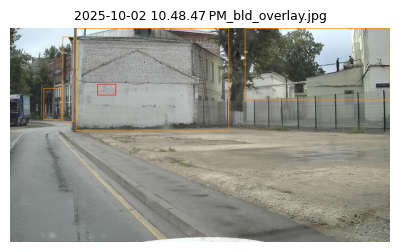

In [13]:
RESULT_CSV  = "/content/out/inference_with_buildings.csv"  # итог предыдущей ячейки
OVERLAY_DIR = "/root/exp_msk/infer/overlays"
K           = 1
SELECT_MODE = "topk_err"             # "topk_err" | "random"
SHOW_N      = 1

import os, json, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from tqdm import tqdm
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 200)

df = pd.read_csv(RESULT_CSV)
if "building_bboxes_json" not in df.columns:
    raise ValueError("В CSV нет колонки 'building_bboxes_json'.")

# выбор изображений
df_sel = df.copy()
if SELECT_MODE == "topk_err" and "err_m" in df_sel.columns:
    df_sel = df_sel.sort_values("err_m", ascending=False, na_position='last')
    df_sel = df_sel.head(K)
else:
    df_sel = df_sel.sample(min(K, len(df_sel)), random_state=42)

OVERLAY_DIR = Path(OVERLAY_DIR); OVERLAY_DIR.mkdir(parents=True, exist_ok=True)

def draw_boxes_pil(img: Image.Image, boxes):
    img = img.copy()
    draw = ImageDraw.Draw(img)
    for b in boxes:
        try:
            x1, y1, x2, y2 = int(b["x1"]), int(b["y1"]), int(b["x2"]), int(b["y2"])
        except Exception:
            # если это строка — распарсим
            if isinstance(b, str):
                b = json.loads(b)
                x1, y1, x2, y2 = int(b["x1"]), int(b["y1"]), int(b["x2"]), int(b["y2"])
            else:
                continue
        draw.rectangle([x1, y1, x2, y2], outline=(255,140,0), width=2)
    return img

saved_paths = []
for _, r in tqdm(df_sel.iterrows(), total=len(df_sel), desc="Draw overlays"):
    img_path = r["image_path"]
    if not os.path.exists(img_path):
        continue
    try:
        boxes = json.loads(r["building_bboxes_json"]) if isinstance(r["building_bboxes_json"], str) else []
    except Exception:
        boxes = []
    try:
        img = Image.open(img_path).convert("RGB")
        vis = draw_boxes_pil(img, boxes)
        out_p = OVERLAY_DIR / (Path(img_path).stem + "_bld_overlay.jpg")
        vis.save(out_p, quality=92)
        saved_paths.append(str(out_p))
    except Exception as e:
        print(f"[WARN] {img_path}: {e}")

print(f"[saved overlays] {len(saved_paths)} files -> {OVERLAY_DIR}")

# показать несколько превью
show_n = min(SHOW_N, len(saved_paths))
if show_n > 0:
    ncols = 3
    nrows = int(np.ceil(show_n / ncols))
    plt.figure(figsize=(4*ncols, 4*nrows))
    for i, p in enumerate(saved_paths[:show_n]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(Image.open(p))
        title = Path(p).name
        plt.title(title, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Nothing to show.")